<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/05_transfer_learning_in_tensorflow_p2_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine Tuning


In [ ]:
!nvidia-smi

Fri Jul 15 15:03:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functins

In previous notebooks we created helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here:

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-15 15:03:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-15 15:03:28 (73.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note -** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models using `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://ww.tensorflow.org/api_docs/python/tf/keras/applications


In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("/content/10_food_classes_10_percent.zip")

--2022-07-15 15:03:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 142.251.18.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  33.5MB/s    in 4.8s    

2022-07-15 15:03:39 (33.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode="categorical",
                                                                         batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

See the data type ´BatchDataSet´? This new object type is what the `image_dataset_from_directory` creates. The shape of the tensor `(None, 224, 224, 3)` has a None as axis 0, and this leads our tensor for different batches

In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

See an example of a batch of data. The `image_dataset_from_directory` function has stored our dataset in different batches.

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[139.5       123.35715    62.571426 ]
   [135.99489   107.7551     52.520405 ]
   [139.78572   101.63775    51.0102   ]
   ...
   [205.71948    85.71949   132.14801  ]
   [203.45413    82.31126   127.239815 ]
   [217.79079    91.24995   134.84685  ]]

  [[144.55612   115.984695   63.34184  ]
   [104.24999    67.68366    23.24489  ]
   [ 96.591835   56.566322   19.97959  ]
   ...
   [184.38266    68.29592   113.73975  ]
   [185.29086    61.948956  108.07143  ]
   [203.82687    71.63806   119.760445 ]]

  [[132.04082    95.46938    53.61224  ]
   [ 96.28061    58.392853   27.637754 ]
   [ 83.69387    47.65306    26.030611 ]
   ...
   [172.72925    60.50982   104.67815  ]
   [173.78061    50.20908    97.4234   ]
   [179.09729    42.15332    92.587036 ]]

  ...

  [[ 85.43889    58.591938   28.796034 ]
   [ 95.97958    63.122437   28.40815  ]
   [105.07141    70.49994    30.285671 ]
   ...
   [220.47966   244.33672   252.04591  ]
   [225.12758   245.0153    254.07144  ]
   [2

## Experiments we will run through this chapter


Experiment | Data | Preprocessing | Model
-----------|------|---------------|-------
Model 0 (baseline) | 10 classes of Food101 data </br>(**random 10% training data only**) | None | **Feature Extractor:** EfficientNetB0 (pre-trained on ImageNet, </br> all layers frozen with no top)
Model 1 | 10 classes of Food101 data (**random 1%** training data only) | Random Flip, Rotation, Zoom, </br>Height, Width, data augmentation | Same as Model 0
Model 2 | Same as Model 0 | Same as Model 1 | Same as Model 0
Model 3 | Same as Model 0 | Same as Model 1 | **Fine-tuning:** Model 2 (EfficientNetB0 pretrained on ImageNet) </br>**with top layer trained on custom data, top 10 layers unfrozen**
Model 4 | 10 classes of Food101 data (**100%** training data) | Same as Model 1 | Same as Model 3

</br>

So far we have only used the sequential api to build models. Now we will start using the [Functional API](https://www.tensorflow.org/guide/keras/functional) which is more flexible and able to produce more sophisticated models. The main difference lies into creating the model. Compiling, fitting and evaluating follow the same procedure

</br>

### Datasets we will be using

</br>

Dataset name | Source | Classes | Training Data | Testing data
-------------|--------|---------|---------------|--------------
pizza_steak | Food101 | pizza, steak (2) | 750 images of pizza and steak </br> (same as original Food101 dataset) | 250 images of pizza and steak </br> (same as original Food101 dataset)
10_food_classes_1_percent | Same as above | Chicken curry, chicken wings </br> fried rice, grilled salmon, </br> hamburger, ice cream, pizza, </br> ramen, steak, sushi (10) | 7 randomly selected images </br> of each class (**1%** of original </br> training data) | 250 images of each class </br> (same as original Food101 </br> dataset)
10_food_classes_10_percent | Same as above | Same as above | 75 randomly selected images </br> of each class (**10%** of original </br> training data) | Same as above
10_food_classes_100_percent | Same as above | Same as above | 750 randomly selected images </br> of each class (**100%** of original training </br> data) | Same as above
101_food_classes_10_percent | Same as above | All classes from Food101 (101) | 75 images of each class (**10%** </br> of original Food101 dataset) | 250 images of each class </br> (same as original Food101 </br> dataset)



## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order. But the functiona API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model (so the underlying pre-trained patterns arent' updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for efficientnets)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (Aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # Feature vector
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs with outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220715-150348
Epoch 1/5
24/24 [==============================] - 20s 241ms/step - loss: 1.9096 - accuracy: 0.4187 - val_loss: 1.3534 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 4s 174ms/step - loss: 1.1766 - accuracy: 0.7227 - val_loss: 0.9490 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - 4s 132ms/step - loss: 0.8664 - accuracy: 0.7933 - val_loss: 0.7618 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.7107 - accuracy: 0.8320 - val_loss: 0.6759 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.6107 - accuracy: 0.8653 - val_loss: 0.6331 - val_accuracy: 0.8257


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.6131 - accuracy: 0.8356


[0.6131269335746765, 0.8356000185012817]

Now let's check the layers in our base model

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

See a summary of the base model

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


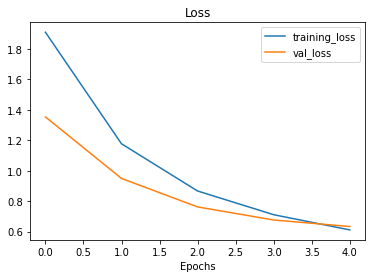

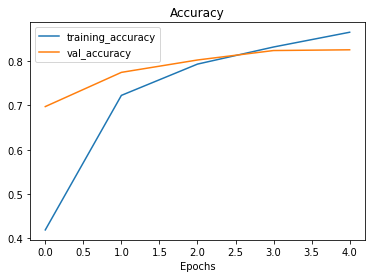

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer. We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

but then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the input shape

input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor}")

random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [ ]:
# Let's repolicate the GlobalAveragePool2D layer

tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create random tensor 
input_shape = (1, 4, 4, 3)
input_tensor = tf.random.normal(input_shape)

input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [ ]:
tf.keras.layers.GlobalMaxPool2D()(input_tensor)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [ ]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data. Let's set up the stated experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> **Note -** Throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency accross evaluation metrics. 

In [ ]:
# Download an unzip data (preprocessed from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2022-07-15 15:04:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  92.5MB/s    in 1.4s    

2022-07-15 15:04:42 (92.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create training and test dirs 
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

## Getting and preprocessing data for model 1

In [ ]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()


We can see the benefits of doing this within the [Tensorflow Data augmentation documentation](https://www.tensorflow.org/tutorials/imags/data_augmentation#use_keras_preprocessing_layers).

Off the top of our heads, after reading the documentation, the benefits of using data augmentation inside the model are:

* Augmenting data as model layers enables the use of GPU, speeding up the training process.

* Since data augmentation is inside the model, when saving and deploying the model this layers will be already there, and there will be no need to reprogram the logic for data augmentation.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescale(1./255) # Keep for models like Resnet50V2 but EfficientNet comes with rescaling
], name= "data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

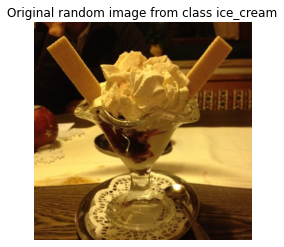

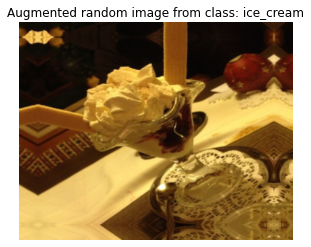

In [ ]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img);
plt.axis("off");
plt.title(f"Original random image from class {target_class}")

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.);
plt.title(f"Augmented random image from class: {target_class}");
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer 
x = data_augmentation(inputs, training=True)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output 
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs 
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220715-150448
Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4049 - accuracy: 0.1571 - val_loss: 2.2285 - val_accuracy: 0.1579
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.1732 - accuracy: 0.2714 - val_loss: 2.1410 - val_accuracy: 0.1941
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9738 - accuracy: 0.3857 - val_loss: 2.0546 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8191 - accuracy: 0.5429 - val_loss: 1.9579 - val_accuracy: 0.3602
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6596 - accuracy: 0.6286 - val_loss: 1.8861 - val_accuracy: 0.4145


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
result_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 1.8883 - accuracy: 0.4040


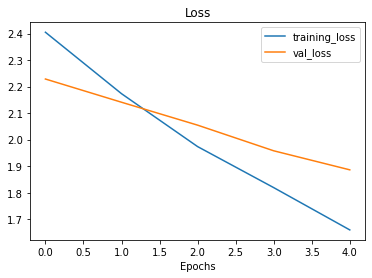

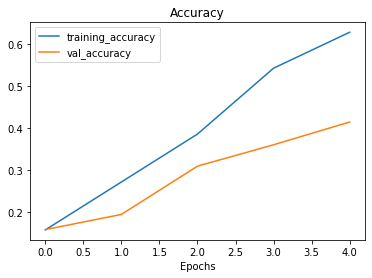

In [ ]:
# How does the model with 1% of the data with augmentation looks on the loss curves?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning on 10% of the data and data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

Set up data loaders for test and training:

In [ ]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

testdata = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Augment data

In [ ]:
# Create model 2 with data augmentation built in

# Create a frozen base model (also called th

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentatin layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)                              
], name="data_augmentation_layer")

# Setup the input shape to our model
input_shape = (224, 224, 3)e backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (doesn't happen on test data)
x = base_model(x, training=False) # We pass the augmented images to the base model, but keep it in inference mode. This ensures batch norm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint Callback

The `ModelCheckpoint` callback intermediately saves our model (the full model or just the weights during training. this is useful so we can comeback and start where we left off)

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkopints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint Callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220715-150536
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0083 - accuracy: 0.3320
Epoch 1: saving model to ten_percent_model_checkopints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 243ms/step - loss: 2.0083 - accuracy: 0.3320 - val_loss: 1.4953 - val_accuracy: 0.6727
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3521 - accuracy: 0.6627
Epoch 2: saving model to ten_percent_model_checkopints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 215ms/step - loss: 1.3521 - accuracy: 0.6627 - val_loss: 1.0721 - val_accuracy: 0.7582
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.7360
Epoch 3: saving model to ten_percent_model_checkopints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 188ms/step - loss: 1.0609 - accuracy: 0.7360 - val_loss: 0.8813 - val_accuracy: 0.7977
Epo

In [ ]:
# What were model_0 resuts
model_0.evaluate(test_data)

79/79 [==============================] - 6s 64ms/step - loss: 0.6131 - accuracy: 0.8356


[0.6131270527839661, 0.8356000185012817]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 64ms/step - loss: 0.6992 - accuracy: 0.8092


[0.6992045640945435, 0.8091999888420105]

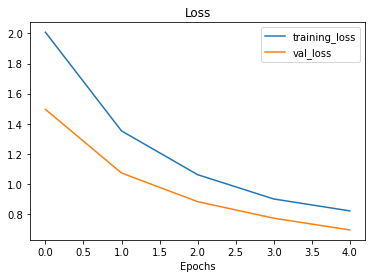

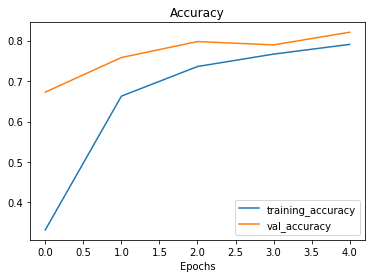

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights regurns a model to a specific checkpoint



In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 64ms/step - loss: 0.6992 - accuracy: 0.8092


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked! 
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6992045640945435, 0.8091999888420105]

In [ ]:
loaded_weights_model_results

[0.6992047429084778, 0.8091999888420105]

From cells 96 to 103 we loaded in the weights from the checkpointed model and we evaluated the model with te test data on the saved weights. Results showed that loaded weights mismatch the results outputting `False`. Do not get afraid, this has to do with the precision used by computers when storing numbers. We can check with the Numpy function `np.isclose()`

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: fine-tuning an existing model on 10% of the data

> **Note -** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in our reloaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2f562f4750> True
<keras.engine.sequential.Sequential object at 0x7f2f562f1fd0> True
<keras.engine.functional.Functional object at 0x7f2f55f24990> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2f562f1f10> True
<keras.layers.core.dense.Dense object at 0x7f2f54bab7d0> True


See all layer objects are trainable except for the Functional object, which is our `base_model`.

In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


To begin finetuning let's start by setting the last 10 layers of our `base_model.trainable = True`

In [ ]:
base_model.trainable = True

# Freeze all layers in base_model except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

> **Note -** When fine-tuning, it is best practice to lower your learning rate  by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim different values). A good resource is the [ULMFit paper](https://arxiv.org/abs/1801.06146) 

In [ ]:
# Check with layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?


In [ ]:
print(len(model_2.trainable_variables))

12


Fine tune for another 5 epochs and refit the model (same as model_2 except with more trainable layers)

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220715-150640
Epoch 5/10
24/24 [==============================] - 15s 307ms/step - loss: 0.7021 - accuracy: 0.8267 - val_loss: 0.5617 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 4s 172ms/step - loss: 0.5344 - accuracy: 0.8413 - val_loss: 0.4939 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 5s 218ms/step - loss: 0.5020 - accuracy: 0.8387 - val_loss: 0.4779 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 5s 201ms/step - loss: 0.4609 - accuracy: 0.8573 - val_loss: 0.4783 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 4s 170ms/step - loss: 0.4075 - accuracy: 0.8747 - val_loss: 0.5086 - val_accuracy: 0.8257
Epoch 10/10
24/24 [==============================] - 4s 167ms/step - loss: 0.3713 - accuracy: 0.8920 - val_loss: 0.4855 - val_accuracy: 0.8322


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actully model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 64ms/step - loss: 0.4912 - accuracy: 0.8364


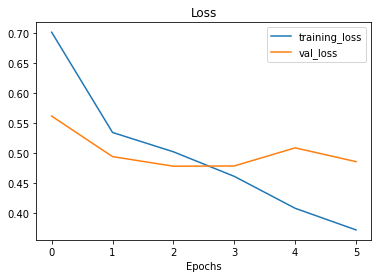

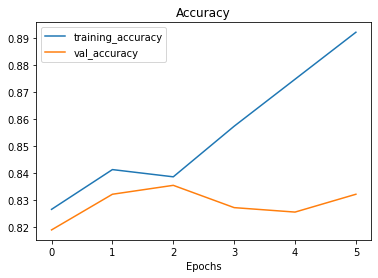

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` functions works great with models which have onoly been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after tuning). In summary we want to compare histories in one single plot

In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects
  """

  # Get original history measurements (Train)
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  # Get original history measurements (Validation data)
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with the new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8));
  plt.subplot(2, 1, 1);
  plt.plot(total_acc, label="Training Loss");
  plt.plot(total_val_acc, label="Val Loss");
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning");
  plt.legend(loc="lower right");
  plt.title("Training and Validation Accuracy")

    # Make plot for loss
  plt.figure(figsize=(8, 8));
  plt.subplot(2, 1, 2);
  plt.plot(total_loss, label="Training Loss");
  plt.plot(total_val_loss, label="Val Loss");
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning");
  plt.legend(loc="upper right");
  plt.title("Training and Validation Loss")

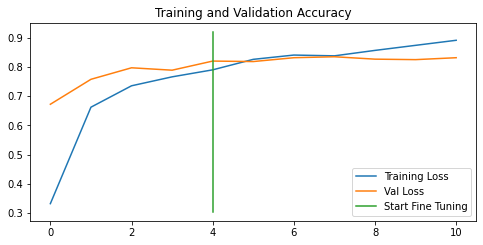

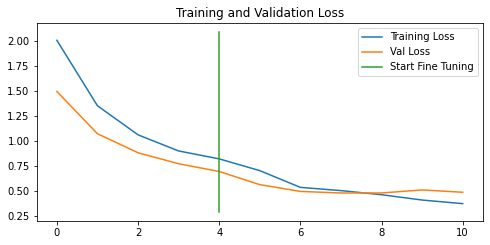

In [ ]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tune an existing model on all of the data

In [ ]:
# download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-07-15 15:42:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   107MB/s    in 5.2s    

2022-07-15 15:42:41 (95.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# setup training and test dir
folder_name = "10_food_classes_all_data"
train_dir = folder_name + "/" + "train"
test_dir = folder_name + "/" + "test"


In [ ]:
# How manhy images are we working with now?
walk_through_dir(folder_name)

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [ ]:
# Setup data inputs

IMG_SIZE= (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


the test dataset we've loaded in is the same as what we've been using for previous experiments (All experiments have used the same test dataset). 
Let's verify this

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.4912 - accuracy: 0.8364


[0.4912312924861908, 0.8363999724388123]

In [ ]:
results_fine_tune_10_percent

[0.4912312924861908, 0.8363999724388123]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

Now we load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 98ms/step - loss: 0.6992 - accuracy: 0.8092


[0.699204683303833, 0.8091999888420105]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6992045640945435, 0.8091999888420105]

The previous steps might seem quite confusing, but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (`model_2`), and saved model's weights using checkpoint callback.

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (`model_3`)

3. Saved results and training logs each time.

4. Reloaded the model from step 1 to do the same steps as step 2, except this time we're going to use all the data

In [ ]:
# Check with layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base model (EfficientNetB0) and see what layers are trainable

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220715-160743
Epoch 5/10
235/235 [==============================] - 33s 111ms/step - loss: 0.7345 - accuracy: 0.7653 - val_loss: 0.4311 - val_accuracy: 0.8536
Epoch 6/10
235/235 [==============================] - 24s 100ms/step - loss: 0.5977 - accuracy: 0.8093 - val_loss: 0.3832 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 22s 92ms/step - loss: 0.5320 - accuracy: 0.8332 - val_loss: 0.3786 - val_accuracy: 0.8799
Epoch 8/10
235/235 [==============================] - 22s 91ms/step - loss: 0.4821 - accuracy: 0.8440 - val_loss: 0.3576 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 23s 95ms/step - loss: 0.4446 - accuracy: 0.8600 - val_loss: 0.3506 - val_accuracy: 0.8816
Epoch 10/10
235/235 [==============================] - 21s 90ms/step - loss: 0.4259 - accuracy: 0.8621 - val_loss: 0.3350 - val_accuracy: 0.8964


Let's evaluate on all of the test data:

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 82ms/step - loss: 0.3265 - accuracy: 0.8884


[0.32654663920402527, 0.8884000182151794]

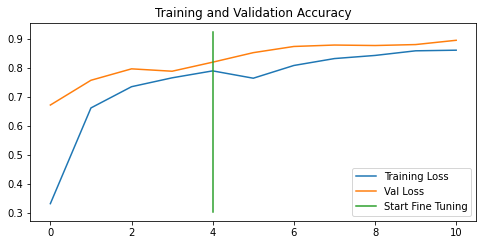

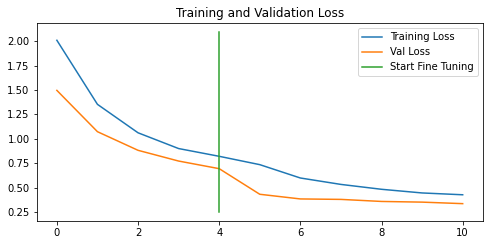

In [ ]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

> **Note -** Anything we upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard log of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload \
--logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food 101 Classes" \
--description "A series of different transfer learning experiment with varying amounts of data and fine tuning" \
--one_shot # Exits the uploader once it's finished uploading

In [ ]:
# View all of uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

https://tensorboard.dev/experiment/Me9iBAnORf2CJU0MO6ymZQ/
	Name                 Transfer Learning Experiments with 10 Food 101 Classes
	Description          A series of different transfer learning experiment with varying amounts of data and fine tuning
	Id                   Me9iBAnORf2CJU0MO6ymZQ
	Created              2022-07-15 16:23:44 (8 minutes ago)
	Updated              2022-07-15 16:23:51 (8 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4321666
https://tensorboard.dev/experiment/Rtdzfy9IRCqbdHOkjUoGww/
	Name                 ResNet50V2 vs EfficientNetB0 vs MobileNet_V2_100_224
	Description          Comparing three different TF Hub feature extraction model architectures using 10% of the training data
	Id                   Rtdzfy9IRCqbdHOkjUoGww
	Created              2022-07-08 11:06:43
	Updated              2022-07-08 11:06:52
	Runs                 6
	Tags                 5
	Scalars            

In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id 